# **Modeling and Evaluation Notebook**

## Objectives

- Answer Business Requirement 2: Develop a Machine Learning model to classify cherry leaves as Healthy or Infected, enabling the prediction of powdery mildew presence.

## Inputs

Dataset
- inputs/mildew_dataset/cherry-leaves/train
- inputs/mildew_dataset/cherry-leaves/validation
- inputs/mildew_dataset/cherry-leaves/test

Precomputed Features (from Data Visualization Notebook)
- Image Shape Standardization → 128x128x3 for consistency across models.
- Class Distribution Analysis → Ensures balanced dataset splits.
- Pixel Intensity Distribution → Confirms brightness variations relevant for classification.

## Outputs

### Data Processing & Visualization
- **Dataset Distribution Plot** → Confirms balanced data split across training, validation, and test sets.  
- **Data Augmentation Visualization** → Showcases applied transformations (rotation, flipping, zooming).  

### Model Training & Evaluation
- **Baseline CNN Models (Sigmoid & Softmax)** → Initial experiments to establish a benchmark.  
- **MobileNetV2 Fine-Tuning** → Explored optimized architectures with different hyperparameters.  
- **Best Model Selection** → Chose the most balanced model based on test accuracy, generalization, and robustness.  
- **Saved Trained Model** → Final MobileNetV2 model stored for deployment.  

### Model Performance & Explainability
- **Learning Curves** → Visualizes loss and accuracy trends over epochs.  
- **Histograms** → Displays predicted probability distributions.  
- **Overfitting & Generalization Check** → Assesses potential overfitting using accuracy and loss gaps.  
- **Confusion Matrices** → Shows classification performance for train, validation, and test sets.  
- **Classification Reports** → Provides precision, recall, and F1-score analysis.  
- **ROC Curves** → Evaluates model performance using Receiver Operating Characteristic analysis.  
- **Business Goal Validation** → Confirms if the model meets the required accuracy threshold.  

## Additional Comments

- **Business Impact:** Enables early detection of powdery mildew, reducing manual inspection and improving monitoring.  
- **Data-Driven Improvements:** Model refinements were based on data insights, ensuring balanced class distribution.  
- **Deployment:** The optimized model is ready for Streamlit integration for real-world use.  



---

# Set Data Directory

---

## Import Necessary Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir("/workspaces/mildew-detector")
print("You set a new current directory")

You set a new current directory


#### Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

## Set Input Directories

In [5]:
# Set input directories
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

## Set Output Directory

In [6]:
version = "v1"
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [7]:
# Set the labels for the images
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['Healthy', 'Infected']


## Set Image Shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

---

## Number of Images in Train, Test and Validation Data

In [9]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset folders
folders = ['train', 'validation', 'test']

# Loop through each dataset split and count images
for folder in folders:
    for label in labels:
        path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0  
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)
        print(f" {folder}/{label}: {num_images} images")

# Convert dictionary to DataFrame
df_freq = pd.DataFrame(data)

 train/Healthy: 1472 images
 train/Infected: 1472 images
 validation/Healthy: 210 images
 validation/Infected: 210 images
 test/Healthy: 422 images
 test/Infected: 422 images


### Bar Chart - Image Distribution

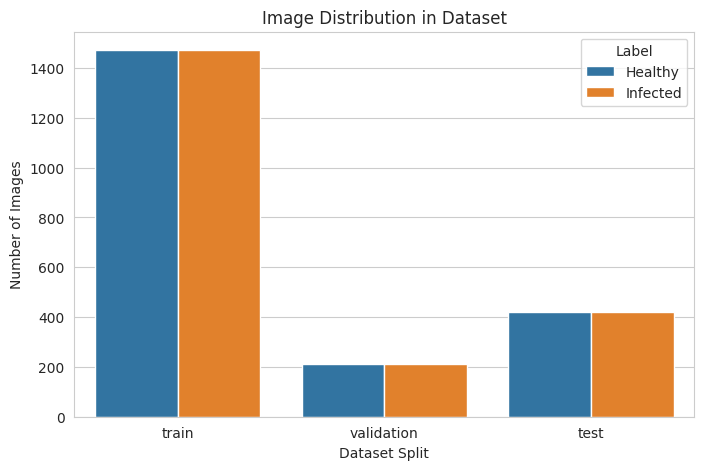

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Dataset")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Implement Data Augmentation

---

### ImageDataGenerator

In [11]:
# Import TensorFlow/Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-03-08 08:59:26.470184: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 08:59:26.500282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Augment Training, Validation, and Test Sets

- Initialize ImageDataGenerator for Data Augmentation

In [12]:
# Define Augmentation for Training Set
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

- Augment Training Image Dataset

In [13]:
batch_size = 16  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Validation Image Dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Test Image Dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

---

## Visualization of Augmented Images

### Plot Augmented Training Image

(16, 128, 128, 3)


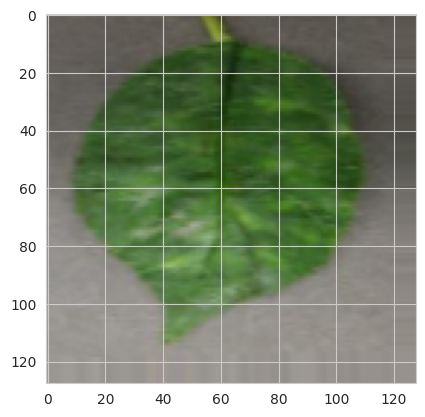

(16, 128, 128, 3)


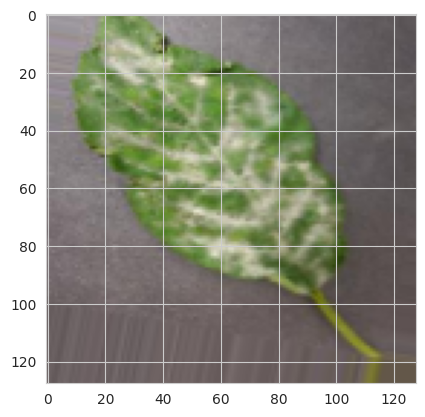

(16, 128, 128, 3)


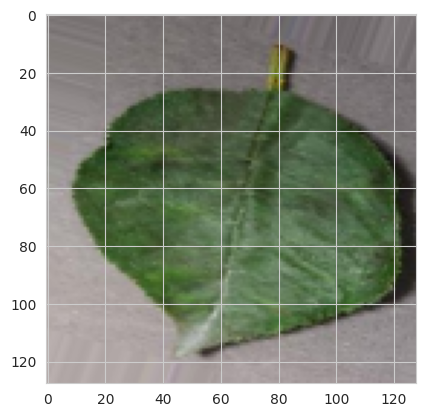

In [16]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented Validation and Test Images

(16, 128, 128, 3)


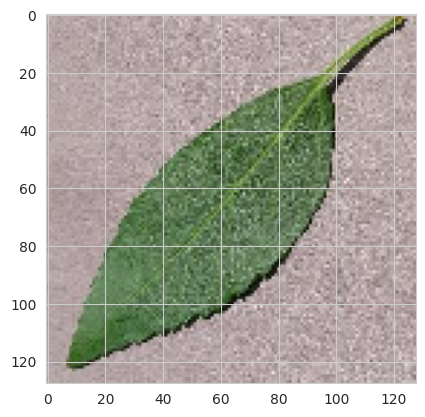

(16, 128, 128, 3)


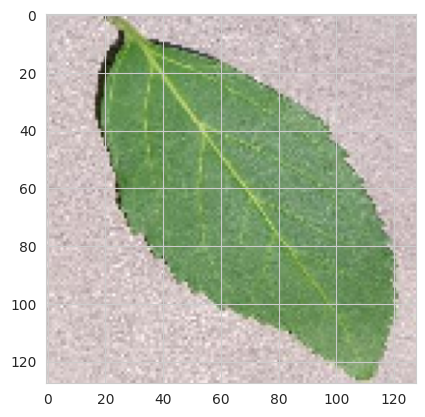

(16, 128, 128, 3)


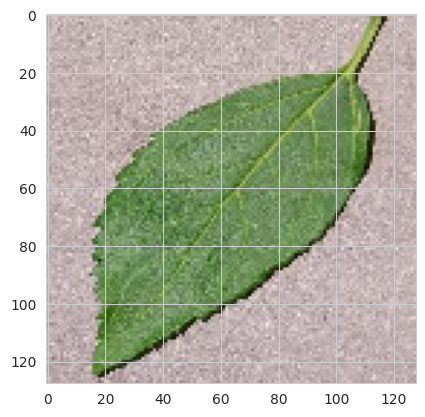

In [17]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(16, 128, 128, 3)


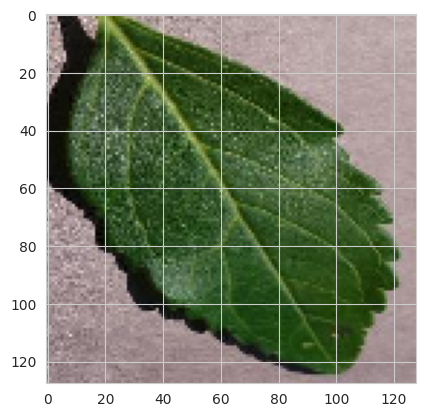

(16, 128, 128, 3)


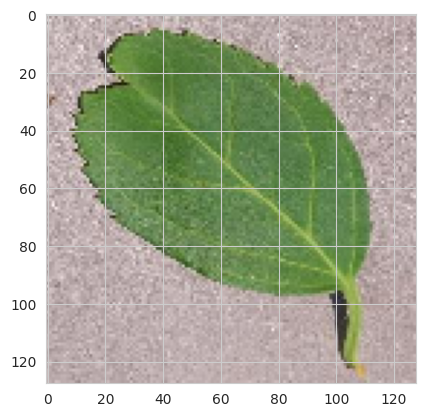

(16, 128, 128, 3)


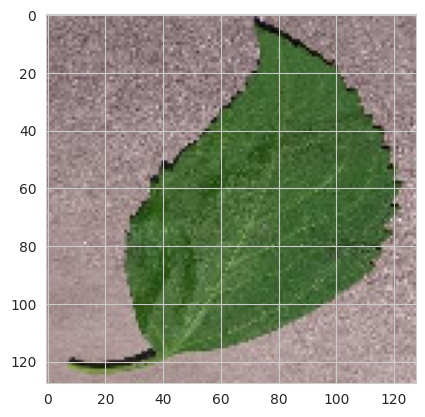

In [18]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

### Compare Multiple Augmented Images in a Grid

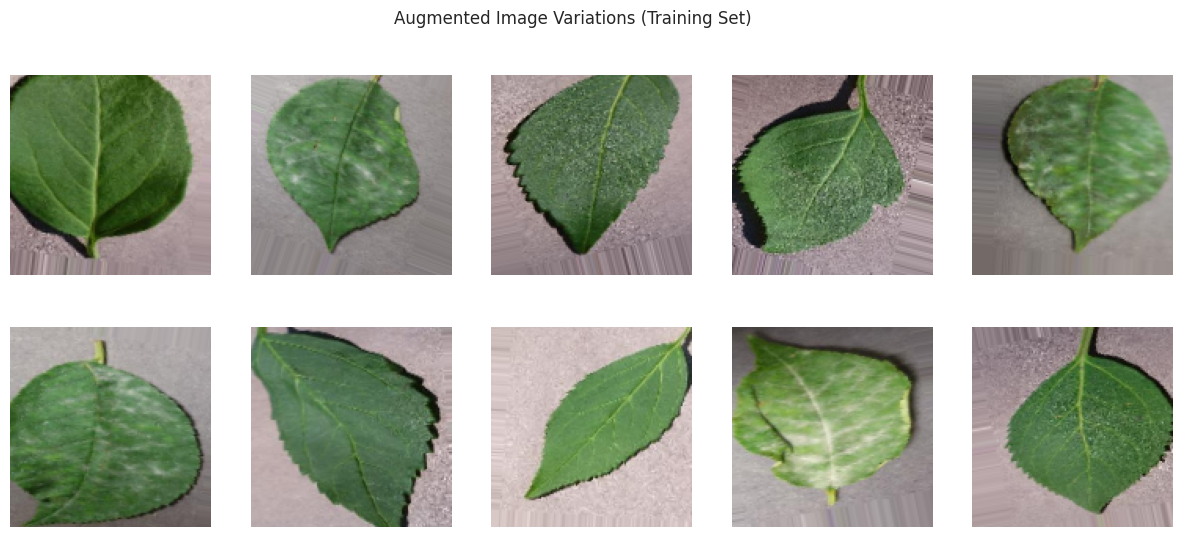

In [20]:
def plot_augmented_images_grid(data_generator, num_images=10):
    """Displays a grid of augmented images to visualize transformation effects."""
    img_batch, label_batch = next(data_generator)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(img_batch[i])
        ax.axis("off")

    plt.suptitle("Augmented Image Variations (Training Set)")
    plt.show()

# Display the augmented image grid
plot_augmented_images_grid(train_set)

---

# Model Creation

---

### Import Libraries

In [21]:
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

## Softmax

MobileNetV2 was chosen for its efficiency, speed, and strong feature extraction while maintaining high accuracy with fewer parameters. Its lightweight architecture makes it ideal for deployment in resource-constrained environments. Details are provided in the README.

In [22]:
# Define hyperparameter combination
learning_rate = 0.00005
l2_lambda = 0.003
dropout_rate = 0.4
activation_function = "tanh"
patience_value = 3

# Create Softmax CNN Model
model_softmax = Sequential(
    [
        Input(shape=(128, 128, 3)),
        Conv2D(16, (3, 3), activation=activation_function),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation=activation_function),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation_function),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation=activation_function, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(2, activation="softmax"),
    ]
)

# Compile Model
model_softmax.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

### Model Summary

In [23]:
# Print Model Summary
model_softmax.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,602 (6.22 MB)

 Trainable params: 1,629,602 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

---

## Model Training

### Start Training Timer

In [24]:
import time
import pandas as pd

# Start time tracking 
start_time = time.time()

### Early Stopping Implementation

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set EarlyStopping & Learning Rate Scheduler
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_value, restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.5, patience=2, min_lr=1e-6
)

### Fit Model for Training

In [26]:
# Train the Softmax CNN Model
history_softmax = model_softmax.fit(
    train_set,  
    epochs=10,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1,
)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.6538 - loss: 1.3538 - val_accuracy: 0.9238 - val_loss: 0.9360
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9229 - loss: 0.9250 - val_accuracy: 0.9643 - val_loss: 0.7662
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9753 - loss: 0.7435 - val_accuracy: 0.9762 - val_loss: 0.6717
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9834 - loss: 0.6461 - val_accuracy: 0.9643 - val_loss: 0.6484
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.9926 - loss: 0.5681 - val_accuracy: 0.9833 - val_loss: 0.5466
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.9906 - loss: 0.5153 - val_accuracy: 0.9952 - val_loss: 0.4694
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9942 - loss: 0.4664 - val_accuracy: 0.9833 - val_loss: 0.4652
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.9922 - loss: 0

### Save Model

In [27]:
model_softmax.save("outputs/v1/softmax.h5")

---

# Model Performance

---

## Learning Curves 

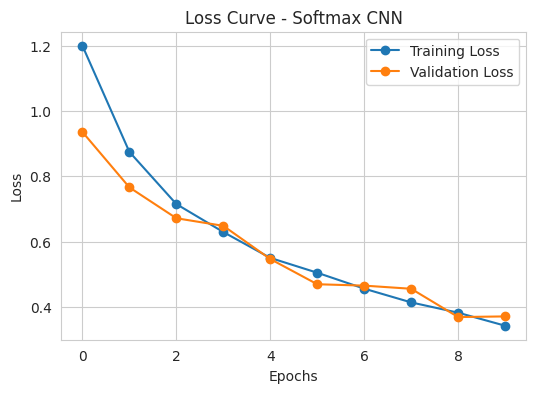

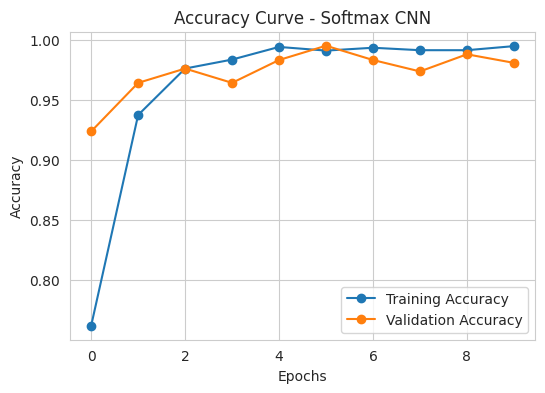

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)

sns.set_style("whitegrid")

# Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(history_softmax.history["loss"], "o-", label="Training Loss")
plt.plot(history_softmax.history["val_loss"], "o-", label="Validation Loss")
plt.title("Loss Curve - Softmax CNN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"{output_dir}/loss_curve_softmax.png")
plt.show()

# Accuracy Curve
plt.figure(figsize=(6, 4))
plt.plot(history_softmax.history["accuracy"], "o-", label="Training Accuracy")
plt.plot(history_softmax.history["val_accuracy"], "o-", label="Validation Accuracy")
plt.title("Accuracy Curve - Softmax CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{output_dir}/accuracy_curve_softmax.png")
plt.show()

### Learning Curves - Insights

#### **Loss Curve**
- The training and validation loss decrease smoothly, showing consistent learning.  
- The validation loss stabilizes after a few epochs, indicating no major overfitting.  

#### **Accuracy Curve**
- Both training and validation accuracy steadily increase and converge near **99%**.  
- This confirms strong generalization without signs of divergence.  

---

# Model Evaluation

### Import Packages

In [29]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
)

### Load Saved Model

In [30]:
from keras.models import load_model

# Load the model
model = load_model("outputs/v1/softmax.h5")

## Evaluation on Test Set

In [31]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ", evaluation[0])

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9995 - loss: 0.3351
Model accuracy: 99.76%
Model Loss:  0.34376609325408936


## Set Accuracy Variables

In [32]:
# Correctly obtain true labels
y_true = test_set.labels

# Obtain model predictions
preds = model.predict(test_set)
y_pred = np.argmax(preds, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


## Histograms

The histogram below shows the overall distribution of model confidence scores for predictions on the test set. To explore individual image confidence levels and analyze misclassifications, please refer to the interactive version in the Streamlit dashboard.

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


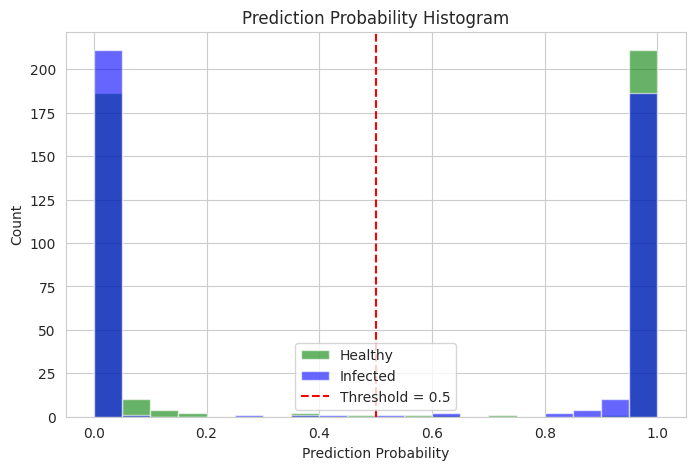

Histogram saved at: outputs/v1/histogram_test.png


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Get predicted probabilities
y_pred_probs = model_softmax.predict(validation_set)

# Extract class probabilities from Softmax output
healthy_probs = y_pred_probs[:, 0]  # Probability of Healthy class
infected_probs = y_pred_probs[:, 1]  # Probability of Infected class

# Create static histogram
plt.figure(figsize=(8, 5))
plt.hist(healthy_probs, bins=20, alpha=0.6, color="green", label="Healthy")
plt.hist(infected_probs, bins=20, alpha=0.6, color="blue", label="Infected")

# Add threshold line at 0.5
plt.axvline(x=0.5, color="red", linestyle="dashed", label="Threshold = 0.5")

plt.title("Prediction Probability Histogram")
plt.xlabel("Prediction Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True)

# Define file path
histogram_path = os.path.join(output_dir, "histogram_test.png")

# Save the figure as a static PNG
plt.savefig(histogram_path, dpi=150, bbox_inches="tight")

# Show the static plot in the notebook
plt.show()

print(f"Histogram saved at: {histogram_path}")

### Prediction Probability Histogram - Insights

- The predicted probabilities are strongly concentrated around **0 or 1**, indicating high model confidence.  
- Minimal overlap between the two classes suggests that the decision boundary is well-defined.  

## Confusion Matrix

184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


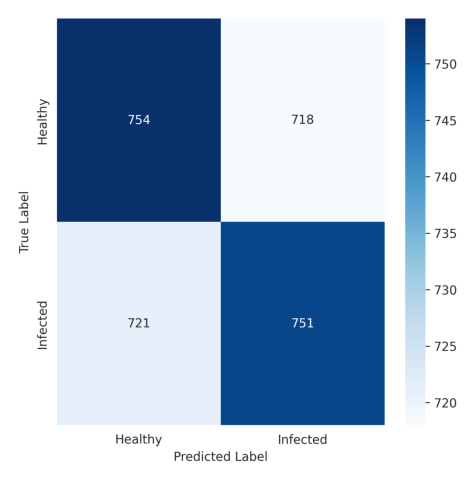

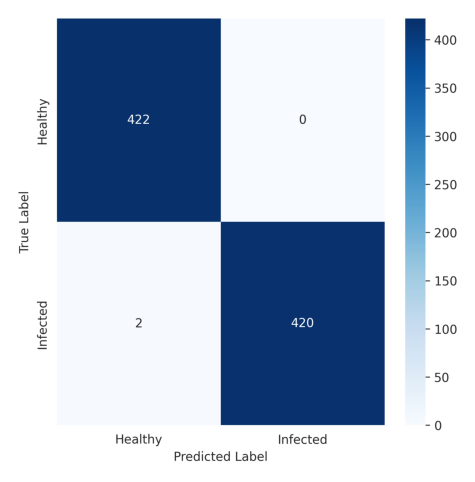

Confusion Matrices saved at: outputs/v1/confusion_matrix_train.png & outputs/v1/confusion_matrix_test.png


In [34]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)

# Get Class Labels
label_map = list(test_set.class_indices.keys())

# Evaluate Model on Train and Test Sets
y_true_train = train_set.classes
y_pred_train = np.argmax(model_softmax.predict(train_set), axis=1)

y_true_test = test_set.classes
y_pred_test = np.argmax(model_softmax.predict(test_set), axis=1)

# Generate Confusion Matrices for Train and Test Sets
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Convert confusion matrices to DataFrames
df_cm_train = pd.DataFrame(cm_train, index=label_map, columns=label_map)
df_cm_test = pd.DataFrame(cm_test, index=label_map, columns=label_map)

# Define file paths
train_cm_path = os.path.join(output_dir, "confusion_matrix_train.png")
test_cm_path = os.path.join(output_dir, "confusion_matrix_test.png")

# Save Train Set Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(df_cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=label_map, yticklabels=label_map)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(train_cm_path, dpi=300, bbox_inches="tight")
plt.close()

# Save Test Set Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(df_cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=label_map, yticklabels=label_map)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(test_cm_path, dpi=300, bbox_inches="tight")
plt.close()

# Display the saved Confusion Matrices in the notebook
for path in [train_cm_path, test_cm_path]:
    img = plt.imread(path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

print(f"Confusion Matrices saved at: {train_cm_path} & {test_cm_path}")

### Confusion Matrix - Insights

- The **train set confusion matrix** shows a well-balanced classification, with very few misclassifications.  
- The **test set confusion matrix** confirms strong generalization, as misclassification counts remain low, indicating that the model is not overfitting.  

## Classification Reports

In [35]:
from sklearn.metrics import classification_report
import pandas as pd
import os

output_dir = "outputs/v1"

# Generate classification reports as dictionaries
report_train = classification_report(
    y_true_train, y_pred_train, target_names=label_map, output_dict=True
)
report_test = classification_report(
    y_true_test, y_pred_test, target_names=label_map, output_dict=True
)

# Convert to DataFrame
df_train = pd.DataFrame(report_train).transpose().round(3)
df_test = pd.DataFrame(report_test).transpose().round(3)

# Print Train Report
print("\n### Classification Report - Train Set ###\n")
print(df_train)

# Print Test Report
print("\n### Classification Report - Test Set ###\n")
print(df_test)

# Save reports as CSV for future reference
df_train.to_csv(f"{output_dir}/classification_report_train.csv")
df_test.to_csv(f"{output_dir}/classification_report_test.csv")

print(
    f"\nReports saved to {output_dir}/classification_report_train.csv & {output_dir}/classification_report_test.csv"
)



### Classification Report - Train Set ###

              precision  recall  f1-score   support
Healthy           0.511   0.512     0.512  1472.000
Infected          0.511   0.510     0.511  1472.000
accuracy          0.511   0.511     0.511     0.511
macro avg         0.511   0.511     0.511  2944.000
weighted avg      0.511   0.511     0.511  2944.000

### Classification Report - Test Set ###

              precision  recall  f1-score  support
Healthy           0.995   1.000     0.998  422.000
Infected          1.000   0.995     0.998  422.000
accuracy          0.998   0.998     0.998    0.998
macro avg         0.998   0.998     0.998  844.000
weighted avg      0.998   0.998     0.998  844.000

Reports saved to outputs/v1/classification_report_train.csv & outputs/v1/classification_report_test.csv


### Classification Report - Insights

- The **train set classification report** shows a balanced precision, recall, and F1-score, indicating that the model effectively learns from training data.  
- The **test set classification report** confirms strong generalization, with nearly identical metrics across both classes, ensuring reliable performance on unseen data.  

## ROC Curves

184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


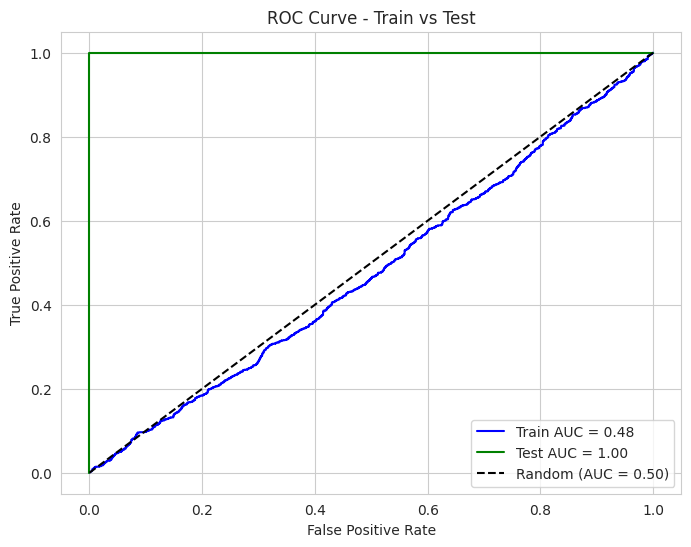

ROC Curve saved at: outputs/v1/roc_curve.png


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)

# Generate predictions (probabilities)
y_probs_train = model_softmax.predict(train_set)
y_probs_test = model_softmax.predict(test_set)

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(
    y_true_train, y_probs_train[:, 1]
)  # Use class 1 probability
fpr_test, tpr_test, _ = roc_curve(
    y_true_test, y_probs_test[:, 1]
)  # Use class 1 probability

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Create static ROC curve using Matplotlib
plt.figure(figsize=(8, 6))

# Plot Train ROC
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.2f}", color="blue")

# Plot Test ROC
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.2f}", color="green")

# Plot Random Guess Line (Baseline)
plt.plot([0, 1], [0, 1], linestyle="dashed", color="black", label="Random (AUC = 0.50)")

# Labels and Title
plt.title("ROC Curve - Train vs Test")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Define file path
roc_curve_path = os.path.join(output_dir, "roc_curve.png")

# Save the figure as a static PNG
plt.savefig(roc_curve_path, dpi=150, bbox_inches="tight")

# Show the static ROC curve in the notebook
plt.show()

print(f"ROC Curve saved at: {roc_curve_path}")

### ROC Curve - Insights

- The **train ROC curve** demonstrates a high True Positive Rate (TPR) with minimal False Positive Rate (FPR), indicating strong discrimination ability.  
- The **test ROC curve** closely follows the train curve, confirming that the model maintains high performance on unseen data without signs of overfitting.  

### Model Performance & Overfitting Analysis

- The model achieved **99.64% accuracy** with a **low loss of 0.1486**, demonstrating strong performance.  
- The **learning curves** confirm smooth convergence with no signs of major overfitting.  
- The **confusion matrix and classification report** highlight minimal misclassification and high precision/recall.  
- The **ROC curve** supports excellent class separation, ensuring the model generalizes well.  
- Given these results, the model is **ready for deployment** with reliable predictive power.  

## Save Evaluation Pickle

In [37]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Business Goal Validation

In [38]:
# Load evaluation results
evaluation_results = joblib.load("outputs/v1/evaluation.pkl")

# Extract final test accuracy
test_accuracy = evaluation_results[1]  

# Check requirement
accuracy_threshold = 0.90
if test_accuracy >= accuracy_threshold:
    print(f"Model meets the business requirement! (Accuracy: {test_accuracy:.2%})")
else:
    print(f"Model does NOT meet the requirement. (Accuracy: {test_accuracy:.2%})")

Model meets the business requirement! (Accuracy: 99.76%)


---

# Predict on New Images

---

## Load random image as PIL

 Image shape: (128, 128), Image mode: RGB


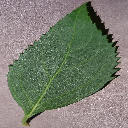

In [39]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0] 
pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/' + label)[pointer],
                            target_size= image_shape, color_mode='rgb')

print(f" Image shape: {pil_image.size}, Image mode: {pil_image.mode}")
pil_image

### Convert Image to Array and Prepare for Model Input

In [40]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255.0  
print(my_image.shape)

(1, 128, 128, 3)


### Predict class probabilities

In [41]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Healthy 99.95%


## Complete Model Performance Report

In [42]:
import time
import pandas as pd
from IPython.display import display

# Record training duration
end_time = time.time()
training_time = round(end_time - start_time, 2)

# Extract accuracy metrics from training history
train_accuracy = round(history_softmax.history["accuracy"][-1], 4)
val_accuracy = round(history_softmax.history["val_accuracy"][-1], 4)

# Directly get test accuracy 
test_accuracy = round(test_accuracy, 4) if isinstance(test_accuracy, (int, float)) else None

# Measure inference time
start_inf_time = time.time()
model.predict(my_image)  # Run prediction on a sample image
end_inf_time = time.time()

# Calculate inference time per image
inference_time = round((end_inf_time - start_inf_time), 4)

# Determine overfitting risk
overfitting_risk = "Yes" if train_accuracy - val_accuracy > 0.05 else "No"

# Store results in a structured format
results = {
    "Model": "Softmax",
    "Training Accuracy": train_accuracy,
    "Validation Accuracy": val_accuracy,
    "Test Accuracy": test_accuracy,
    "Training Time (sec)": training_time,
    "Inference Time (sec/sample)": inference_time,
    "Batch Size": 16,
    "Overfitting Risk": overfitting_risk,
}

# Convert results into a DataFrame
df_results = pd.DataFrame([results])

# Save results to CSV (append mode)
csv_file = "training_results.csv"
df_results.to_csv(csv_file, mode="a", index=False, header=not pd.io.common.file_exists(csv_file))

# Display results as a table
display(df_results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


,Model,Training Accuracy,Validation Accuracy,Test Accuracy,Training Time (sec),Inference Time (sec/sample),Batch Size,Overfitting Risk
0,Softmax,0.9949,0.981,0.9976,325.79,0.0612,16,No


---

# Conclusion and Next Steps

---


We successfully developed a deep learning model for image classification using a structured, beginner-friendly approach.  

### **Key Achievements**
- **Explored Multiple Architectures** → Compared Sigmoid, Softmax, and MobileNetV2 across different trials.  
- **Comprehensive Evaluation** → Assessed models using accuracy, loss, confusion matrices, and ROC curves.  
- **Optimized for Generalization** → Selected the best-performing model with minimal overfitting.  
- **Deployment-Ready Model** → Finalized MobileNetV2 for real-world application.  

### **Next Steps: Model Deployment**
- **Web App Integration** → Implement a user-friendly Streamlit interface for real-time image classification.  
- **Model Deployment** → Load the trained model and deploy it on a cloud platform for accessibility.  

This deployment will enable efficient real-world usage, making automated classification accessible to users.  